In [1]:
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import timeit

In [3]:
# The naive approach

def process_data(filepath1, chunk_size=1000):
    n = 0
    Sum = 0
    SumSq = 0

    with open(filepath1, 'rb') as f:
        while True:
            data = f.read(chunk_size)
            if not data:
                break
            x = np.frombuffer(data, dtype=np.uint8).astype("uint64")
            n += x.size
            Sum += x.sum()
            SumSq += (x * x).sum()

    mean = Sum / n
    variance = (SumSq - (Sum * Sum) / n) / (n - 1)
    return mean, variance


# run the naive algorithm
filepath1 = "homework2_upload_2023/measurement_data_2023_uint8.bin"
start_time = timeit.default_timer()
mean, variance = process_data(filepath1)
print("execution time for the naive approach is " f'{timeit.default_timer() - start_time:.4f}')
print("Mean computed naively:", mean)
print("Variance computed naively:", variance)
print("std computed naively:", mth.sqrt(variance))

execution time for the naive approach is 7.2188
Mean computed naively: 133.700091185
Variance computed naively: 1.787860463471454
std computed naively: 1.3371089946116788


In [4]:
# Welford's algorithm - https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance

def getInitVals(filepath1, chunk_size=1000):
    with open(filepath1, 'rb') as f:
        while True:
            init = f.read(chunk_size)
            x = np.frombuffer(init, dtype=np.uint8).astype("uint64")
            mean = np.mean(x)
            count = len(x)
            m2 = np.sum(np.subtract(x, [mean] * count)**2)
            break

    init_vals = (count, mean, m2)    
    return init_vals

def welford_update(existingAggregate, newValues):
    (count, mean, M2) = existingAggregate
    count += len(newValues)
    # newvalues - oldMean
    delta = np.subtract(newValues, [mean] * len(newValues))
    mean += np.sum(delta / count)
    # newvalues - newMean
    delta2 = np.subtract(newValues, [mean] * len(newValues))
    M2 += np.sum(delta * delta2)

    return (count, mean, M2)

def welford_finalize(existingAggregate):
    (count, mean, M2) = existingAggregate
    (mean, variance, sampleVariance) = (mean, M2/count, M2/(count - 1))
    if count < 2:
        return float('nan')
    else:
        return (mean, variance, sampleVariance)

def welford_process(filepath1, chunk_size=1000):
    new_agg = getInitVals(filepath1)

    with open(filepath1, 'rb') as f:
        itr = 0
        while True:
            data = f.read(chunk_size)
            if not data:
                break
            x = np.frombuffer(data, dtype=np.uint8).astype("uint64")

            if itr == 0:
                pass
            else:
                new_agg = welford_update(new_agg, x)

            itr += 1

    result = welford_finalize(new_agg)
    return result


# run the Welford algorithm on the data samples
start_time = timeit.default_timer()
res = welford_process(filepath1)
print("execution time for the Welford algorithm is " f'{timeit.default_timer() - start_time:.4f}')
print("Mean computed with Welford algo:", res[0])
print("Variance computed with Welford algo:", res[2])
print("std computed with Welford algo:", mth.sqrt(res[2]))

execution time for the Welford algorithm is 105.0684
Mean computed with Welford algo: 133.70009118499533
Variance computed with Welford algo: 1.7878604634731188
std computed with Welford algo: 1.3371089946123011


In [5]:
# One-pass arbitrary order method - https://eprint.iacr.org/2015/207.pdf, only Section 4 and Appendix A

def one_pass_init(filepath1, chunk_size=1000):
    with open(filepath1, 'rb') as f:
        while True:
            init = f.read(chunk_size)
            x = np.frombuffer(init, dtype=np.uint8).astype("uint64")
            mean = np.mean(x)
            count = len(x)
            cs2 = np.sum(np.subtract(x, [mean] * count)**2)
            break
    
    init_vals = (count, mean, cs2)
    return init_vals

def one_pass_update(existingAggregate, newValues):
    (count, mean, cs2) = existingAggregate
    # newvalues - oldMean
    delta = np.subtract(newValues, [mean] * len(newValues))
    count += len(newValues)
    mean += np.sum(delta / count)
    cs2 += np.sum((delta**2 * (count - 1)) / count)

    return (count, mean, cs2)

def one_pass_finalize(existingAggregate):
    (count, mean, cs2) = existingAggregate
    (mean, variance) = (mean, cs2/count)
    if count < 2:
        return float('nan')
    else:
        return (mean, variance)
    
def one_pass_process(filepath1, chunk_size=1000):
    new_agg = one_pass_init(filepath1)

    with open(filepath1, 'rb') as f:
        itr = 0
        while True:
            data = f.read(chunk_size)
            if not data:
                break
            x = np.frombuffer(data, dtype=np.uint8).astype("uint64")
    
            if itr == 0:
                pass
            else:
                new_agg = one_pass_update(new_agg, x)

            itr += 1

    result = one_pass_finalize(new_agg)
    return result


# run the One-pass arbitrary order algorithm on the data samples
start_time = timeit.default_timer()
res = one_pass_process(filepath1)
print("execution time for the One-pass arbitrary order method is " f'{timeit.default_timer() - start_time:.4f}')
print("Mean computed with One-pass algo:", res[0])
print("Variance computed with One-pass algo:", res[1])
print("std computed with One-pass algo:", mth.sqrt(res[1]))

execution time for the One-pass arbitrary order method is 66.5173
Mean computed with One-pass algo: 133.70009118499533
Variance computed with One-pass algo: 1.7878604689246376
std computed with One-pass algo: 1.337108996650848


In [6]:
# Histogram method - https://eprint.iacr.org/2017/624.pdf, only Section 3 and 4

def hist_process(filename, chunk_size=1024):
    histogram = np.zeros(256, dtype=int)

    with open(filename, 'rb') as f:
        while True:
            data = f.read(chunk_size)
            if not data:
                break

            x = np.frombuffer(data, dtype=np.uint8).astype("uint64")
            histogram_chunk, _ = np.histogram(x, bins=256, range=(0, 256), density=False)
            histogram += histogram_chunk

    mean = np.average(range(256), weights=histogram)
    variance = np.average((range(256) - mean)**2, weights=histogram)
    return (mean, variance)
    

# run the Histogram method on the data samples
start_time = timeit.default_timer()
res = hist_process(filepath1)
print("execution time for the histogram method is " f'{timeit.default_timer() - start_time:.4f}')
print("Mean computed with One-pass algo:", res[0])
print("Variance computed with One-pass algo:", res[1])
print("std computed with One-pass algo:", mth.sqrt(res[1]))

execution time for the histogram method is 93.6992
Mean computed with One-pass algo: 133.700091185
Variance computed with One-pass algo: 1.7878604616852958
std computed with One-pass algo: 1.3371089939437606


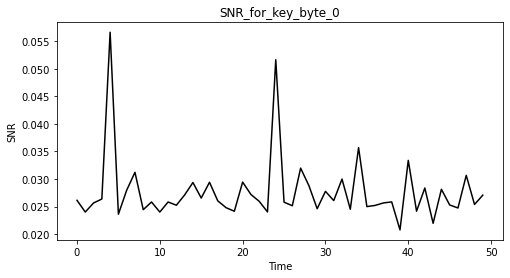

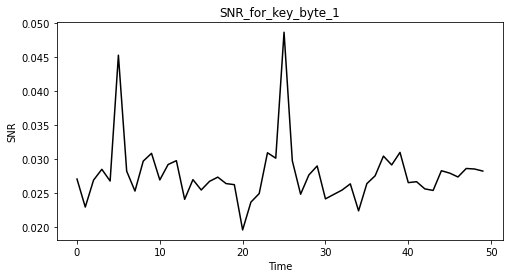

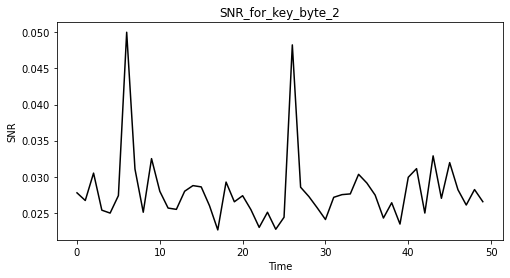

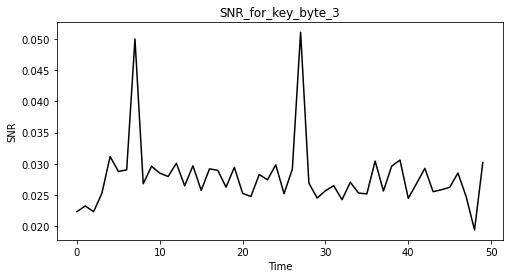

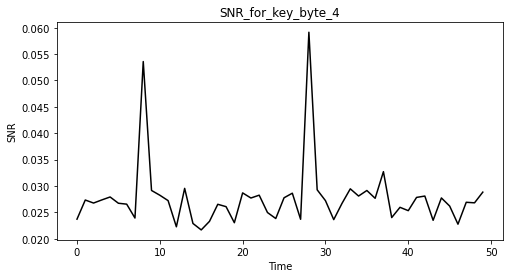

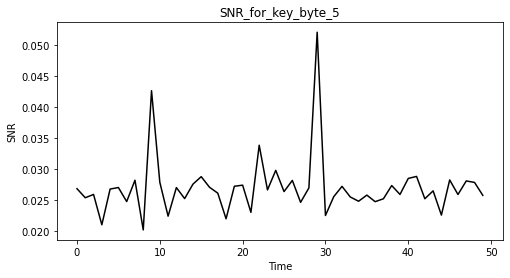

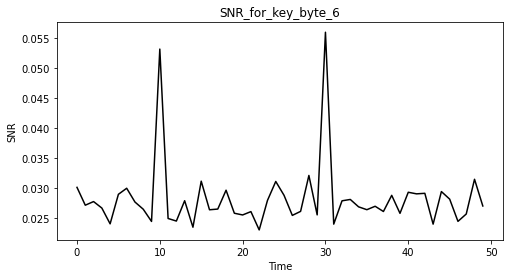

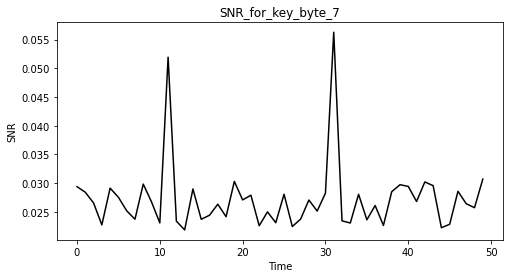

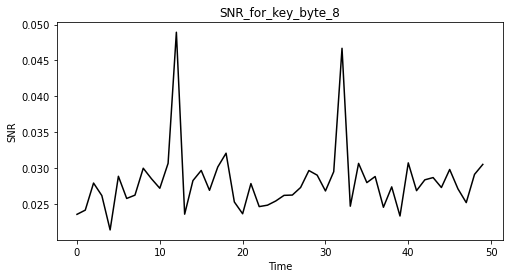

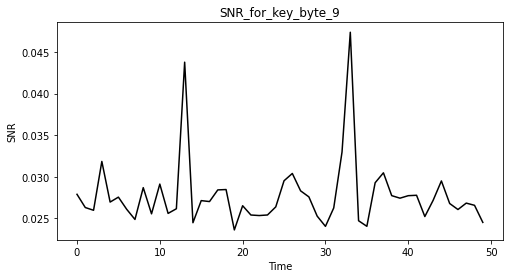

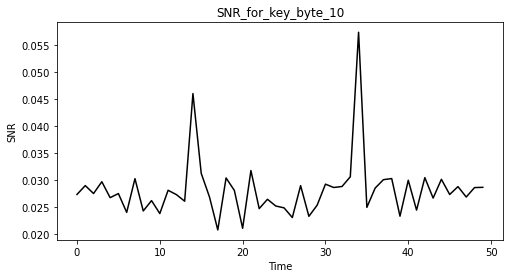

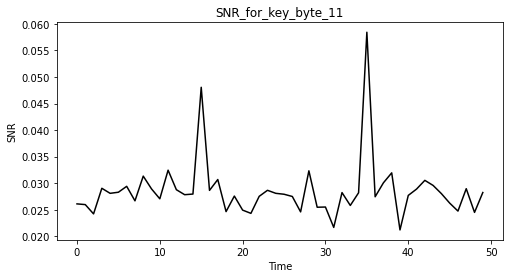

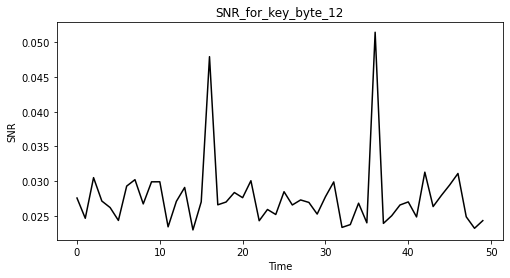

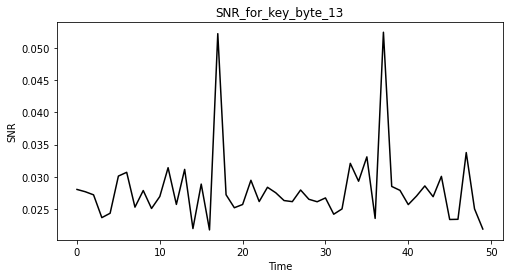

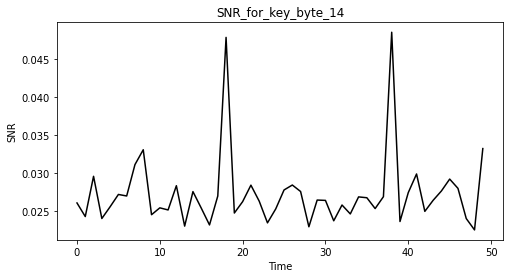

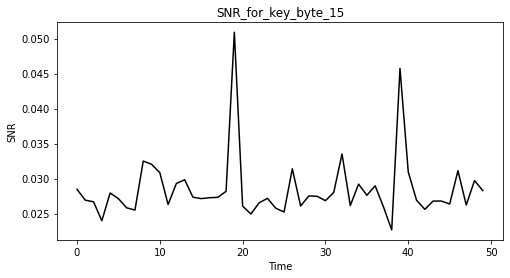

In [13]:
# extracting the SNRs
filepath2 = "homework2_upload_2023/traces_10000x50_int8.bin"
filepath3 = "homework2_upload_2023/plaintext_10000x16_uint8.bin"

trace = np.fromfile(filepath2, dtype=np.int8).reshape(10000, 50)
plaintext = np.fromfile(filepath3, dtype=np.uint8).reshape(10000, 16)

for byte in range(16):
    num = []
    denum = []
    for i in range(256):
        mask2 = (plaintext[:, byte] == i)
        rows = np.where(mask2)[0]
        selected_rows_in_trace = trace[rows, :]

        if selected_rows_in_trace.shape[0] != 0:
            num.append(np.mean(selected_rows_in_trace, axis=0))
            denum.append(np.var(selected_rows_in_trace, axis=0))
    
    signal = np.var(num, axis=0)
    noise = np.mean(denum, axis=0)
    SNR = np.divide(signal, noise)

    # Plot the graphs for the signal, noise and SNR
    %matplotlib inline
    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax1.plot(signal, 'blue', label='signal')
    ax1.plot(noise, 'red', label='noise')

    dest1 = "figures/" + "key_" + "byte_" + str(byte)
    title1 = "signal_and_noise_for_key_" + "byte_" + str(byte)

    ax1.set_title(title1)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('signal')
    ax1.legend()

    plt.savefig(dest1)
    plt.show()

    %matplotlib inline
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(SNR, 'black')

    dest2 = "figures/" + "key_" + "byte_" + str(byte)
    title = "SNR_for_key_" + "byte_" + str(byte)

    plt.title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('SNR')

    plt.savefig(dest2)
    plt.show()

In [13]:
sbox = [
0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16
]

sbox_arr = np.array(sbox).reshape(16,16)

In [14]:
# CPA implementation

def find_key(pos):
    # get the plaintext byte
    byte = plaintext[:, pos]

    # get the possible subkeys
    keys = np.arange(256, dtype=np.uint8)

    # repeat the plaintext byte along the columns to form a matrix of shape (10000, 256)
    byte_matrix = np.repeat(byte[:, np.newaxis], keys.shape[0], axis=1)

    # repeat the keys along the columns to form a matrix of shape (10000, 256)
    keys_matrix = np.tile(keys, (byte.shape[0], 1))

    # XOR each element in the plaintext matrix and keys_matrix
    xored_result = np.bitwise_xor(byte_matrix, keys_matrix)

    # do the Sbox substitution on the xored result to get the hypothetical intermediate values
    x_axis = xored_result >> 4
    y_axis = xored_result & 15
    sub_res = sbox_arr[x_axis.reshape(1,2560000), y_axis.reshape(1,2560000)].reshape(10000, 256)

    # apply the Hamming weight power leakage model to the intermediate values
    hypo = (sub_res & 0x55) + (sub_res >>  1 & 0x55) # put count of each  2 bits into those  2 bits 
    hypo = (hypo & 0x33) + (hypo >>  2 & 0x33)  # put count of each  4 bits into those  4 bits 
    hypo = (hypo & 0x0F) + (hypo >>  4 & 0x0F) # put count of each  8 bits into those  8 bits

    # apply the correlation coefficient to extract the probable value for the guessed key byte
    results = []
    for i in range(256):
        hypo_col = hypo[:, i]
        corrs = []
        for j in range(50):
            trace_col = trace[:, j]
            corr = np.corrcoef(trace_col, hypo_col)[0,1]
            corrs.append(corr)
        results.append(max(corrs))
    
    return np.argmax(results)


In [18]:
start_time = timeit.default_timer()
output = []
for pos in range(16):
    output.append(find_key(pos))
print("execution time for the CPA attack is " f'{timeit.default_timer() - start_time:.4f}')
print("The extracted key bytes are: ", output)

execution time for the CPA attack is 26.5757
The extracted key bytes are:  [237, 58, 24, 116, 22, 40, 132, 182, 197, 231, 224, 64, 215, 78, 87, 187]
